# 1. Benchmark Creation

In [10]:
from collections import Counter
import pandas as pd, json

with open("stories/ttcw_short_stories_internal.json", "r") as f:
    stories = json.load(f)

with open("tests/ttcw_all_tests.json", "r") as f:
    tests = json.load(f)

with open("annotations/ttcw_annotations.json", "r") as f:
    annotations = json.load(f)

# Each of the 14 tests was completed by 3 independent expert annotators.
# 48 stories x 14 tests x 3 annotators = 2016 annotations
print("Total of %d annotations" % len(annotations))

def full_prompt2context(full_prompt):
    # remove the last two non-empty lines
    lines = full_prompt.strip().split("\n")
    kept1 = "\n".join(lines[:-1]).strip().split("\n")
    kept2 = kept1[:-1]
    return "\n".join(kept2).strip()

for test in tests:
    test["expanded_context"] = full_prompt2context(test["full_prompt"])

dataset = []

for story in stories:
    if "http" in story["content"]:
        print(f"---\nSkipping story {story['story_idx']} because it contains a link. If you want to include this sample and its annotation, visit the URL {story['content']} and replace the URL with the full story in `stories/ttcw_short_stories.json`. (We do not have permission to publicly distribute New Yorker stories.)")
        continue

    for test in tests:
        all_labels = Counter()
        for anno in annotations:
            if anno["story_id"] == story["story_id"] and test["ttcw_idx"] == anno["ttcw_idx"]:
                all_labels[anno["binary_verdict"]] += 1


        label = all_labels.most_common(1)[0][0]
        sample_id = "story_%s_test%d" % (story["story_id"], test["ttcw_idx"])
        sample = {"id": sample_id, "story": story["content"], "story_id": story["story_id"], "torrance_dimension": test["torrance_dimension"], "category": test["category"], "question": test["question"], "expanded_context": test["expanded_context"], "label": label}
        dataset.append(sample)

# Uncomment below will overwrite file, so be careful
# with open("data/crea_eval_dataset.json", "w") as f:
#     json.dump(dataset, f, indent=2)

Total of 2016 annotations


# 2. Populate LLM judgements

To populate the judgements of a given LLM, you can run the script `run_llm_eval.py` (and modify the part the API call to the LLM of your choice).

This script will populate the judgements of the LLM for the given benchmark.

# 3. Evaluation Analysis

## 3.1 Indivual Test Analysis

We first analyze model ability at performing individual tests, and analyze performance overall, and break it down by test.

In [2]:
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score
import os, json, pandas as pd, numpy as np
from matplotlib import pyplot as plt
from collections import Counter
from numpy import corrcoef

with open("data/crea_eval_dataset.json", "r") as f:
    dataset = json.load(f)

with open("tests/ttcw_all_tests.json", "r") as f:
    tests = json.load(f)

test_names_map = {f"test{d['ttcw_idx']}": f"{d['torrance_dimension']} - {d['category']}" for d in tests}

for d in dataset:
    d["label"] = 1 if d["label"] == "Yes" else 0

models = [fn.replace("annotations_", "").replace(".jsonl", "") for fn in os.listdir("data") if fn.startswith("annotations_") and fn.endswith(".jsonl")]
labels = [d["label"] for d in dataset]

per_story_results = {}
per_test_labels = {}
for d in dataset:
    _, story_idx, origin, test_id = d["id"].split("_")
    story_id = "%s_%s" % (story_idx, origin)

    per_test_labels.setdefault(test_id, []).append(d["label"])
    if story_id not in per_story_results:
        per_story_results[story_id] = {"human": 0}
    per_story_results[story_id]["human"] += d["label"]

results = []
ratio_positive_row = {"model": "ratio_positive"}
ratio_positive_row.update({test_id: sum(per_test_labels[test_id]) / len(per_test_labels[test_id]) for test_id in per_test_labels})
per_test_results = [ratio_positive_row]

for model in models:
    with open("data/annotations_%s.jsonl" % model, "r") as f:
        annotations = [json.loads(line) for line in f]

    pred_map = {}
    for a in annotations:
        pred_map[a["id"]] = 1 if a["response"].lower().startswith("yes") else 0
    
    preds = []
    per_test_preds = {test_id: [] for test_id in per_test_labels}
    for d in dataset:
        pred = pred_map.get(d["id"], 0)
        _, story_idx, origin, test_id = d["id"].split("_")
        story_id = "%s_%s" % (story_idx, origin)
        per_test_preds[test_id].append(pred)
        if model not in per_story_results[story_id]:
            per_story_results[story_id][model] = 0
        per_story_results[story_id][model] += pred
        preds.append(pred)

    N_found = len([d for d in dataset if d["id"] in pred_map])
    results.append({"model": model, "balanced_accuracy": balanced_accuracy_score(labels, preds), "precision": precision_score(labels, preds), "recall": recall_score(labels, preds),
                    "f1": f1_score(labels, preds), "corr": corrcoef(labels, preds)[0, 1], "N_found": N_found})

    # Per-test results, only compute bacc
    res_row = {"model": model}
    for test_id in per_test_labels:
        res_row["%s" % test_id] = balanced_accuracy_score(per_test_labels[test_id], per_test_preds[test_id])

    per_test_results.append(res_row)

for row in per_test_results:
    row["avg_bacc"] = np.mean([v for k, v in row.items() if k != "model"])

# The corr column gives averaged correlation across the 14 tests. This roughly corresponds to the "Average Row" in Table 9 of the paper (https://arxiv.org/abs/2309.14556).    
pd.DataFrame(results).set_index("model").sort_values("balanced_accuracy").round(2)

,balanced_accuracy,precision,recall,f1,corr,N_found
model,,,,,,
gemini-pro,0.46,0.32,0.83,0.46,-0.12,658
cgpt,0.49,0.33,0.66,0.44,-0.02,672
claudev2,0.50,0.34,0.79,0.47,-0.00,672
claudev21,0.52,0.35,0.86,0.50,0.06,672
claudev13,0.53,0.36,0.73,0.48,0.06,672
gpt4,0.54,0.36,0.85,0.51,0.10,672
claude3-opus,0.58,0.39,0.83,0.53,0.18,672


In [3]:
print(test_names_map) # This can help understand map the test ID to the actual test name

per_test_results = sorted(per_test_results, key=lambda x: x["avg_bacc"], reverse=True)

# This reports per-test performance. This corresponds the the entire Table 9 in the paper (https://arxiv.org/pdf/2309.14556.pdf)
# Note: We switched to balanced accuracy instead of correlation, which is a bit more interpretable (due to binary labels/predictions).
pd.DataFrame(per_test_results).set_index("model").style.background_gradient(cmap='Greens', axis=None).format("{:.2f}")

{'test1': 'Fluency - Narrative Ending', 'test2': 'Fluency - Understandability and Coherence', 'test3': 'Fluency - Scene vs Summary', 'test4': 'Fluency - Narrative Pacing', 'test5': 'Fluency - Language Proficiency and Literary Devices', 'test6': 'Flexibility - Emotional Flexibility', 'test7': 'Flexibility - Structural Flexibility', 'test8': 'Flexibility - Perspective and Voice Flexibility', 'test9': 'Originality - Originality in Thought', 'test10': 'Originality - Originality in Form and Structure', 'test11': 'Originality - Originality in Theme and Content', 'test12': 'Elaboration - Rhetorical Complexity', 'test13': 'Elaboration - World Building and Setting', 'test14': 'Elaboration - Character Development'}


,test1,test2,test3,test4,test5,test6,test7,test8,test9,test10,test11,test12,test13,test14,avg_bacc
model,,,,,,,,,,,,,,,
claude3-opus,0.53,0.47,0.61,0.50,0.52,0.50,0.53,0.64,0.92,0.66,0.65,0.50,0.50,0.65,0.58
gpt4,0.50,0.45,0.48,0.50,0.50,0.50,0.53,0.68,0.56,0.53,0.51,0.50,0.50,0.50,0.52
claudev13,0.48,0.46,0.54,0.52,0.54,0.53,0.39,0.61,0.58,0.58,0.57,0.48,0.50,0.47,0.52
claudev21,0.46,0.53,0.53,0.49,0.43,0.50,0.53,0.66,0.52,0.46,0.51,0.50,0.54,0.41,0.50
claudev2,0.51,0.45,0.51,0.50,0.40,0.50,0.46,0.62,0.44,0.48,0.46,0.51,0.50,0.41,0.48
cgpt,0.41,0.45,0.48,0.35,0.41,0.48,0.49,0.51,0.55,0.56,0.44,0.50,0.55,0.44,0.47
gemini-pro,0.48,0.47,0.46,0.51,0.52,0.52,0.41,0.42,0.30,0.51,0.42,0.39,0.48,0.45,0.45
ratio_positive,0.31,0.46,0.52,0.56,0.27,0.33,0.31,0.23,0.33,0.21,0.25,0.27,0.52,0.17,0.34


## 3.2: Per-Story Evaluation

Fourteen tests are performed for each story. In this section, we count the number of tests passed for each story for each evaluator.

Each story receives an overall score between 0 (none of the tests passed) and 14 (all tests passed).

We then analyze the correlation of this score with expert-given scores.

In [4]:
story_ids = list(per_story_results.keys())
human_scores = [per_story_results[story_id]["human"] for story_id in story_ids]

evaluator_scores = {}
for model in models:
    evaluator_scores[model] = [per_story_results[story_id][model] for story_id in story_ids]

# calculate corrs per model
aggregate_corrs = [{"model": model, "correlation": np.corrcoef(human_scores, evaluator_scores[model])[0, 1]} for model in models]
model2corr = {row["model"]: row["correlation"] for row in aggregate_corrs}
sorted_models = sorted(models, key=lambda x: model2corr[x], reverse=True)

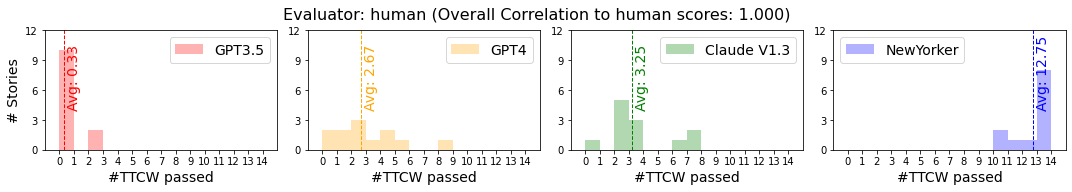

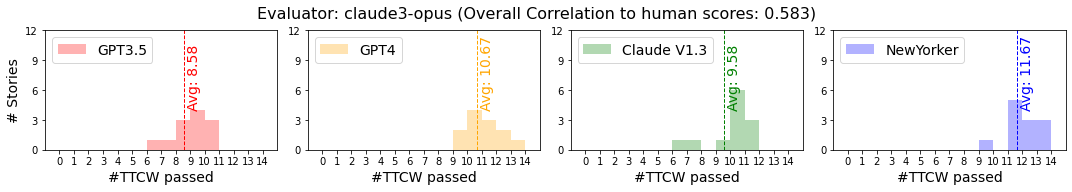

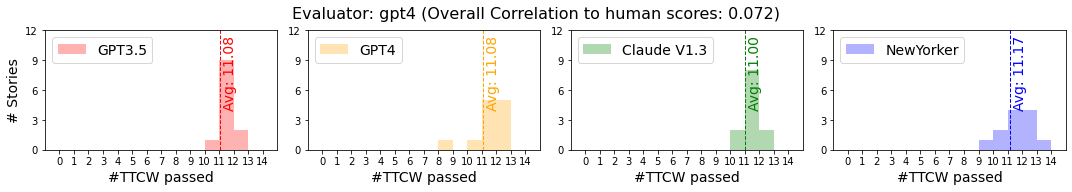

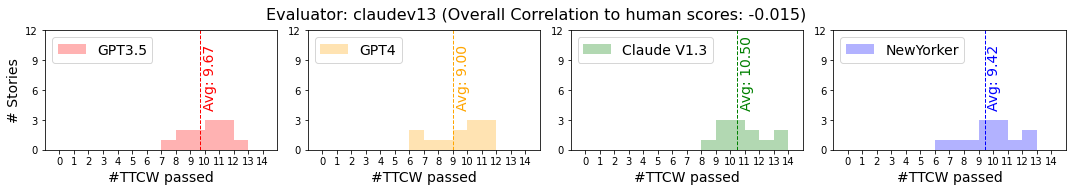

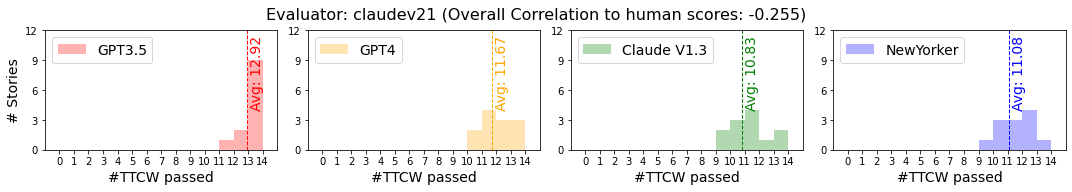

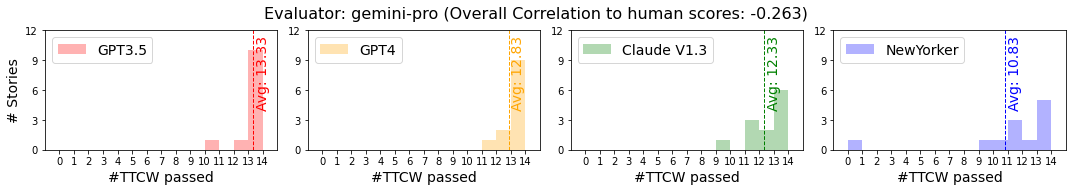

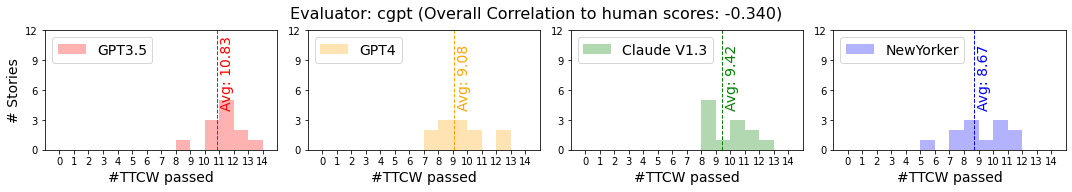

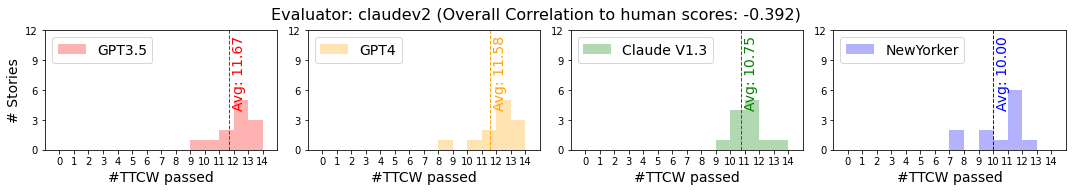

In [5]:
writers = ["GPT3.5", "GPT4", "Claude", "NewYorker"]
colors = ["red", "orange", "green", "blue"]
def plot_score_histograms(writer_histos, evaluator_name):
    fig, axs = plt.subplots(1, len(writers), figsize=(15, 2.5))  # Create subplots

    aggregate_corr = np.corrcoef(human_scores, [per_story_results[story_id][evaluator_name] for story_id in story_ids])[0, 1]

    for i, writer in enumerate(writers):
        data = writer_histos[writer]
        writer_label = "Claude V1.3" if writer == "Claude" else writer
        axs[i].hist(data, alpha=0.3, color=colors[i], label=writer_label, bins=range(15))
        
        # Calculate average and add a line and text
        avg = np.mean(data)
        axs[i].axvline(avg, color=colors[i], linestyle='dashed', linewidth=1)
        axs[i].text(avg + 0.2, 4, f'Avg: {avg:.2f}', color=colors[i], rotation=90, verticalalignment='bottom', fontsize=14)
        
        axs[i].set_xlabel("#TTCW passed", fontsize=14)
        if i == 0:
            axs[i].set_ylabel("# Stories", fontsize=14)
        axs[i].set_xlim(-1, 15)
        axs[i].set_xticks(range(15))
        axs[i].set_yticks(range(0, 15, 3))
        if i == 3 or evaluator_name != "human":
            axs[i].legend(loc='upper left', fontsize=14)
        else:
            axs[i].legend(loc='upper right', fontsize=14)

    plt.tight_layout()
    plt.suptitle(f"Evaluator: {evaluator_name} (Overall Correlation to human scores: {aggregate_corr:.3f})", fontsize=16, y=1.05)
    plt.show()

for model in ["human"] + sorted_models:
    writer_histos = {writer: [] for writer in writers}
    for story_id in per_story_results:
        _, writer = story_id.split("_")
        writer_histos[writer].append(per_story_results[story_id][model])
    plot_score_histograms(writer_histos, model)
    # This Table expands Figure 3 from the paper (https://arxiv.org/pdf/2309.14556.pdf).\
    # The difference in distribution of human scores (first row) is due to this Table aggregating the results of the three experts, whereas the paper's Figure reports each expert individually.